In [2]:
import sys 
sys.path.append('..')
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
import numpy as np
from utils import losses
import pytorch_lightning as pl

from architectures import AR, GRU, LSTM, TGCN

## Plotting packages
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

In [14]:
df_gru = pd.read_csv("../predictions/predictions_GRU_laced-hill-568.csv", parse_dates=['Date'])
df_gru_pnll = pd.read_csv("../predictions/predictions_GRU_laced-hill-568.csv", parse_dates=['Date'])
#df_lstm = df_lstm.drop(columns='Unnamed: 0')
df_gru = df_gru.rename(columns={'WEBSTER_pred':'GRU_pred'})

In [15]:
df_tgcn = pd.read_csv("../predictions/predictions_tgcn_sparkling-leaf-4.csv", parse_dates=['Date'])
df_tgcn = df_tgcn.drop(columns='Unnamed: 0')
df_tgcn = df_tgcn.rename(columns={'WEBSTER_pred':'TGCN_pred'})
df_gru['TGCN_pred'] = df_tgcn['TGCN_pred']

In [16]:
plot_template = dict(
    layout=go.Layout({
        "font_size": 12,
        "xaxis_title_font_size": 14,
        "yaxis_title_font_size": 14})
    )

df_gru.set_index('Date', inplace=True, drop=True)
fig = px.line(df_gru, labels=dict(created_at="Date", value="Sessions"))
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.06, title_text="")
)

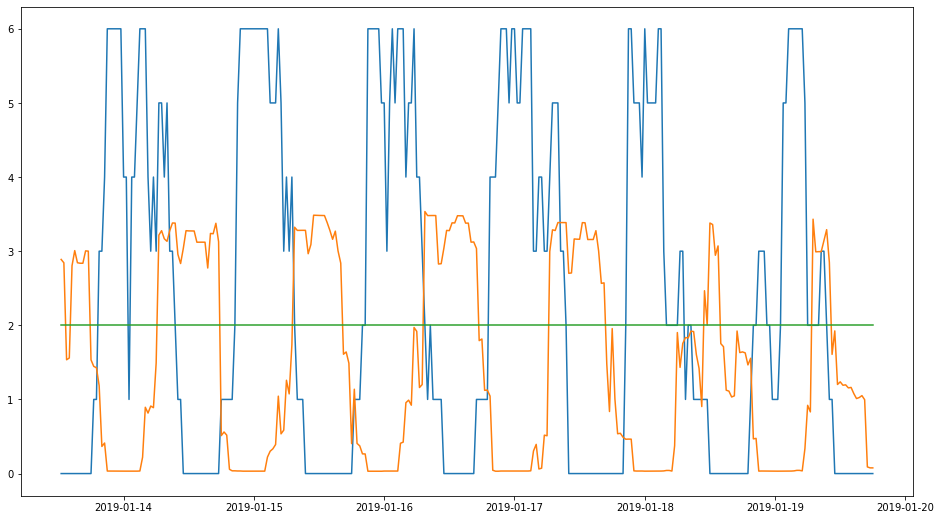

In [36]:
start_obs = 600
end_obs = 900
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(df_gru.index[start_obs:end_obs], df_gru['WEBSTER_true'][start_obs:end_obs], label = 'True observations')
ax.plot(df_gru.index[start_obs:end_obs], df_gru['GRU_pred'][start_obs:end_obs], label = 'Censor-aware GRU_pred')
ax.plot(df_gru.index[start_obs:end_obs], df_gru['GRU_PNLL_pred'][start_obs:end_obs], label = 'Classic GRU_pred')
#ax.plot(df_gru.index[start_obs:end_obs], df_gru['TGCN_pred'][start_obs:end_obs], label = 'TGCN_pred')
ax.plot(df_gru.index[start_obs:end_obs], np.ones(len(df_gru.index[start_obs:end_obs]))*2, label = f'$\tau$', color = 'gray', alpha = 0.7)
ax.legend()

In [37]:
df_gru

,WEBSTER,GRU_pred,WEBSTER_true,TGCN_pred
Date,,,,
2019-01-01 00:30:00,2.0,1.642089,4.0,0.031541
2019-01-01 01:00:00,2.0,2.101917,4.0,0.031546
2019-01-01 01:30:00,2.0,3.289094,5.0,0.031549
2019-01-01 02:00:00,2.0,3.416633,5.0,0.031553
2019-01-01 02:30:00,2.0,3.255715,4.0,0.031556
...,...,...,...,...
2019-05-01 22:00:00,2.0,0.981289,6.0,0.030528
2019-05-01 22:30:00,2.0,1.160656,6.0,0.111298
2019-05-01 23:00:00,2.0,1.533803,6.0,0.117743


In [39]:
df_tgcn

,Date,BRYANT,CAMBRIDGE,HAMILTON,HIGH,MPL,RINCONADA,TED,WEBSTER,BRYANT_pred,...,TED_pred,TGCN_pred,BRYANT_true,CAMBRIDGE_true,HAMILTON_true,HIGH_true,MPL_true,RINCONADA_true,TED_true,WEBSTER_true
0,2019-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.044700,...,0.031537,0.031541,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.044697,...,0.031541,0.031546,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2019-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.044699,...,0.031545,0.031549,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2019-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.044704,...,0.031548,0.031553,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2019-01-01 02:30:00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.044711,...,0.031551,0.031556,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5802,2019-05-01 21:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030408,...,0.031758,0.031763,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5803,2019-05-01 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.030114,...,0.030429,0.030528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5804,2019-05-01 22:30:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.030925,...,0.234385,0.111298,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5805,2019-05-01 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.031237,...,0.239033,0.117743,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
